In [2]:
import os
import sys
import argparse
import cv2
import math, scipy
import time
import numpy as np
import util
from config_reader import config_reader
from scipy.ndimage.filters import gaussian_filter

from model.cmu_model import get_testing_model
import matplotlib.pyplot as plt

import pandas as pd

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [4]:


# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
           [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
           [1, 16], [16, 18], [3, 17], [6, 18]]

# the middle joints heatmap correpondence
mapIdx = [[31, 32], [39, 40], [33, 34], [35, 36], [41, 42], [43, 44], [19, 20], [21, 22], \
          [23, 24], [25, 26], [27, 28], [29, 30], [47, 48], [49, 50], [53, 54], [51, 52], \
          [55, 56], [37, 38], [45, 46]]

# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0],
          [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255],
          [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]


def process (input_image, params, model_params,old_peaks,scale_search):

    oriImg = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)

#     scale_search = [0.7]#[1, .5, 1.5, 2] # [.5, 1, 1.5, 2]
    scale_search = scale_search[0:process_speed]

    
    multiplier = [np.round(x,2) * np.round(model_params['boxsize'],2) / np.round(oriImg.shape[1],2) for x in scale_search]
  
    heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
    paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

    for m in range(len(multiplier)):
        scale = multiplier[m]
        imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        # imageToTest = scipy.misc.imresize(oriImg, int(scale*100), interp='cubic')
        imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'],
                                                          model_params['padValue'])

        input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels)

        output_blobs = model.predict(input_img)

        # extract outputs, resize, and remove padding
        heatmap = np.squeeze(output_blobs[1])  # output 1 is heatmaps
        heatmap = cv2.resize(heatmap, (0, 0), fx=model_params['stride'], fy=model_params['stride'],
                             interpolation=cv2.INTER_CUBIC)
        heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3],
                  :]
        heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

        paf = np.squeeze(output_blobs[0])  # output 0 is PAFs
        paf = cv2.resize(paf, (0, 0), fx=model_params['stride'], fy=model_params['stride'],
                         interpolation=cv2.INTER_CUBIC)
        paf = paf[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
        paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

        heatmap_avg = heatmap_avg + heatmap / len(multiplier)
        paf_avg = paf_avg + paf / len(multiplier)

    all_peaks = []
    peak_counter = 0

    for part in range(18):
        map_ori = heatmap_avg[:, :, part]
        map = gaussian_filter(map_ori, sigma=3)

        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]

        peaks_binary = np.logical_and.reduce(
            (map >= map_left, map >= map_right, map >= map_up, map >= map_down, map > params['thre1']))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        
#         print('peaks=',peaks)
        
        peaks_with_score =[]

        

        ### check old peaks
        x_old_peaks = None
        if old_peaks is not None:
            if old_peaks[part] != []:
                x_old_peaks = old_peaks[part][0][0:2]
#                 print('x_old_peak_part=',x_old_peaks)
    
        if len(peaks)==0:
            if x_old_peaks is not None:
                peaks2 = [x_old_peaks]
            else:
                peaks2 =[]
        elif len(peaks) ==1:
            peaks2 = peaks
        else:
            mindis = np.inf
            maxscore = 0.7
            for i,x in enumerate(peaks):
                if x_old_peaks is not None:
                    dis = np.power(x[1] - x_old_peaks[1],2) + np.power(x[1] - x_old_peaks[1],2)
                    if dis < mindis:
                        peaks2 = [x]
                        mindis = dis
                else:
                    score = map_ori[x[1], x[0]]
                    if score > maxscore:
                        peaks2 = [x]
                        maxscore = score
                    else:
                        peaks2 =[]
                            
#         print('peaks2=',peaks2)
#         print('map_ori[x[1], x[0]]=',[map_ori[x[1], x[0]] for x in peaks2])
        peaks_with_score = [x + (map_ori[x[1], x[0]],) for x in peaks2]
            
#         ## Remove uncertained points
#         peaks2 = []
#         for x in peaks:
#             if (map_ori[x[1], x[0]] > 0.7):
#                 peaks_with_score.append(x + (map_ori[x[1], x[0]],))
#                 peaks2.append(x)
                
        id = range(peak_counter, peak_counter + len(peaks2))
        peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]
        
                
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks2)
        
#     for i,x in enumerate(all_peaks):
#         if not x:
#             if old_peaks is not None:
#                 all_peaks[i] = old_peaks[i]
            
    connection_all = []
    special_k = []
    mid_num = 10

    for k in range(len(mapIdx)):
        score_mid = paf_avg[:, :, [x - 19 for x in mapIdx[k]]]
        candA = all_peaks[limbSeq[k][0] - 1]
        candB = all_peaks[limbSeq[k][1] - 1]
        nA = len(candA)
        nB = len(candB)
        indexA, indexB = limbSeq[k]
        if (nA != 0 and nB != 0):
            connection_candidate = []
            for i in range(nA):
                for j in range(nB):
                    vec = np.subtract(candB[j][:2], candA[i][:2])
                    norm = math.sqrt(vec[0] * vec[0] + vec[1] * vec[1])
                    # failure case when 2 body parts overlaps
                    if norm == 0:
                        continue
                    vec = np.divide(vec, norm)

                    startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                   np.linspace(candA[i][1], candB[j][1], num=mid_num)))

                    vec_x = np.array(
                        [score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                         for I in range(len(startend))])
                    vec_y = np.array(
                        [score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                         for I in range(len(startend))])

                    score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                    score_with_dist_prior = sum(score_midpts) / len(score_midpts) + min(
                        0.5 * oriImg.shape[0] / norm - 1, 0)
                    criterion1 = len(np.nonzero(score_midpts > params['thre2'])[0]) > 0.8 * len(
                        score_midpts)
                    criterion2 = score_with_dist_prior > 0
                    if criterion1 and criterion2:
                        connection_candidate.append([i, j, score_with_dist_prior,
                                                     score_with_dist_prior + candA[i][2] + candB[j][2]])

            connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
            connection = np.zeros((0, 5))
            for c in range(len(connection_candidate)):
                i, j, s = connection_candidate[c][0:3]
                if (i not in connection[:, 3] and j not in connection[:, 4]):
                    connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                    if (len(connection) >= min(nA, nB)):
                        break

            connection_all.append(connection)
        else:
            special_k.append(k)
            connection_all.append([])
        
#     print(all_peaks)  

    # last number in each row is the total parts number of that person
    # the second last number in each row is the score of the overall configuration
    subset = -1 * np.ones((0, 20))
    candidate = np.array([item for sublist in all_peaks for item in sublist])

    for k in range(len(mapIdx)):
        if k not in special_k:
            partAs = connection_all[k][:, 0]
            partBs = connection_all[k][:, 1]
            indexA, indexB = np.array(limbSeq[k]) - 1

            for i in range(len(connection_all[k])):  # = 1:size(temp,1)
                found = 0
                subset_idx = [-1, -1]
                for j in range(len(subset)):  # 1:size(subset,1):
                    if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                        subset_idx[found] = j
                        found += 1

                if found == 1:
                    j = subset_idx[0]
                    if (subset[j][indexB] != partBs[i]):
                        subset[j][indexB] = partBs[i]
                        subset[j][-1] += 1
                        subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                elif found == 2:  # if found 2 and disjoint, merge them
                    j1, j2 = subset_idx
                    membership = ((subset[j1] >= 0).astype(int) + (subset[j2] >= 0).astype(int))[:-2]
                    if len(np.nonzero(membership == 2)[0]) == 0:  # merge
                        subset[j1][:-2] += (subset[j2][:-2] + 1)
                        subset[j1][-2:] += subset[j2][-2:]
                        subset[j1][-2] += connection_all[k][i][2]
                        subset = np.delete(subset, j2, 0)
                    else:  # as like found == 1
                        subset[j1][indexB] = partBs[i]
                        subset[j1][-1] += 1
                        subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(20)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    row[-1] = 2
                    row[-2] = sum(candidate[connection_all[k][i, :2].astype(int), 2]) + \
                              connection_all[k][i][2]
                    subset = np.vstack([subset, row])

    # delete some rows of subset which has few parts occur
    deleteIdx = [];
    for i in range(len(subset)):
        if subset[i][-1] < 4 or subset[i][-2] / subset[i][-1] < 0.4:
            deleteIdx.append(i)
    subset = np.delete(subset, deleteIdx, axis=0)

    canvas = input_image

#     print len(all_peaks)
#     print all_peaks
#     print '='*100
    
    for i in range(18):
        for j in range(len(all_peaks[i])):
            cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

    stickwidth = 2

    for i in range(17):
        for n in range(len(subset)):
            index = subset[n][np.array(limbSeq[i]) - 1]
            if -1 in index:
                continue
            cur_canvas = canvas.copy()
            Y = candidate[index.astype(int), 0]
            X = candidate[index.astype(int), 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY), int(mX)), (int(length / 2), stickwidth), int(angle), 0,
                                       360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)

    return canvas,all_peaks


start processing...
346


<IPython.core.display.Javascript object>


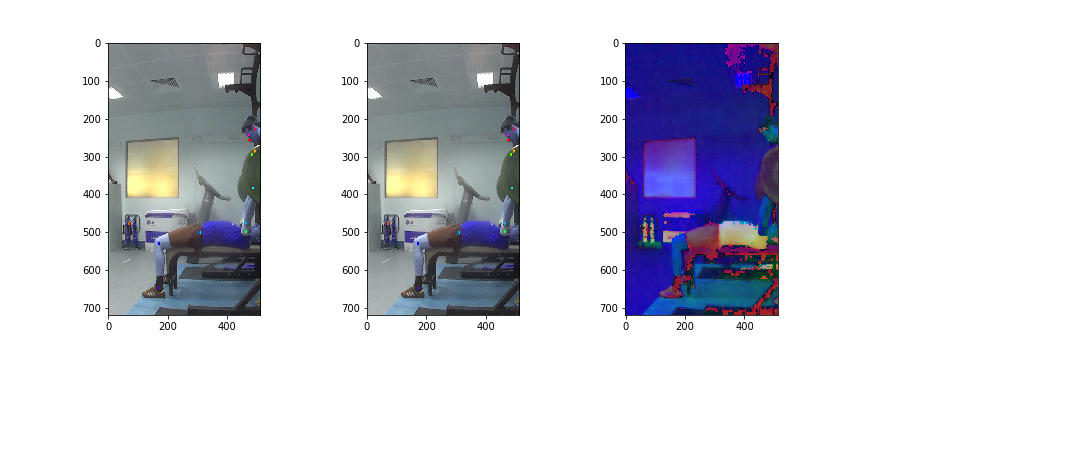

(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)
(720, 512)
(720, 512, 3)


KeyboardInterrupt: 

In [6]:
from IPython import display
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import numpy as np
import pandas as pd
import imutils

%matplotlib inline
%matplotlib notebook


currentDT = time.localtime()
start_datetime = time.strftime("-%m-%d-%H-%M-%S", currentDT)

keras_weights_file = 'model/keras/model.h5'
frame_rate_ratio = 1
process_speed = 4
ending_frame = None  # End frame

print('start processing...')

# Video input
video = 'P2 Saggital 1_495_507.mp4'
video_path = '../data/'
video_file = video_path + video

# Output location
# output_path = './videos/outputs/'
# output_format = '.avi'
# video_output = output_path + video + str(start_datetime) + output_format

# load model
# authors of original model don't use
# vgg normalization (subtracting mean) on input images
model = get_testing_model()
model.load_weights(keras_weights_file)

# load config
params, model_params = config_reader()

# Video reader
cam = cv2.VideoCapture(video_file)
# cam.set(cv2.CAP_PROP_POS_FRAMES, 45000-1)

length = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )

input_fps = cam.get(cv2.CAP_PROP_FPS)
ret_val, input_image = cam.read()

video_length = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))

if ending_frame == None:
    ending_frame = video_length


# Crop image
width = input_image.shape[1]
height = input_image.shape[0]
factor = 0.3
resize_fac = 1

cropped = input_image[:,int(width*factor):int(width*(1-factor))]
cropped = cv2.resize(cropped, (0, 0), fx=1.0/resize_fac, fy=1.0/resize_fac, interpolation=cv2.INTER_CUBIC)


    
# Video writer
output_fps = input_fps / frame_rate_ratio
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter(video_output,fourcc, output_fps, (cropped.shape[1], cropped.shape[0]))

i = 0 # default is 0
resize_fac = 1

# Plotting
grid = plt.GridSpec(1, 3, wspace=0.7, hspace=0.7)
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(grid[0:,0])
ax2 = fig.add_subplot(grid[0:,1])
ax3 = fig.add_subplot(grid[0:,2])
# ax4 = fig.add_subplot(grid[0:,1])

# # fig.show()
old_peaks = None
df_timeseries_x = pd.DataFrame([],columns=np.arange(18))
df_timeseries_y = pd.DataFrame([],columns=np.arange(18))


plt.ion()
fig.show()
fig.canvas.draw()

first_frame = cropped

first_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
first_gray = cv2.GaussianBlur(first_frame, (5, 5), 0)

greenLower = (29, 86, 6)
greenUpper = (64, 255, 255)

scale_search = [0.7]
while(cam.isOpened()) and ret_val == True and i < ending_frame:
    ret_val, input_image = cam.read()
    i += 1
    if i%frame_rate_ratio == 0:

        tic = time.time()
        
        # Crop image
        width = input_image.shape[1]
        height = input_image.shape[0]
        
        cropped = input_image[:,int(width*factor):int(width*(1-factor))]
        cropped = cv2.resize(cropped, (0, 0), fx=1.0/resize_fac, fy=1.0/resize_fac, interpolation=cv2.INTER_CUBIC)

        
#         frame = imutils.resize(input_image, width=600)
#         blurred = cv2.GaussianBlur(input_image, (11, 11), 0)
        hsv = cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, greenLower, greenUpper)
        mask = cv2.erode(mask, None, iterations=2)
        mask = cv2.dilate(mask, None, iterations=2)
         # generate image with body parts
            
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        print(mask.shape)
        print(cropped.shape)
        
        mask = np.dstack((mask,mask,mask))
        img = cv2.add(cropped,mask)
        
        canvas,all_peaks = process(cropped, params, model_params,old_peaks,scale_search)
        
        old_peaks = all_peaks
#         print('Processing frame: ', i)
#         toc = time.time()
#         print ('processing time is %.5f' % (toc - tic))
#         out.write(canvas)
        
        df_timeseries_x = df_timeseries_x.append(pd.DataFrame([e[0] for each in all_peaks  for e in each]).T, ignore_index=True)
        df_timeseries_y = df_timeseries_y.append(pd.DataFrame([e[1] for each in all_peaks  for e in each]).T, ignore_index=True)


#         img = cv2.add(cropped,difference)
    
        ## plot        
        ax1.clear()
        ax1.imshow(canvas, aspect='auto')

        ## plot        
        ax2.clear()
        ax2.imshow(canvas, aspect='auto')

        ## plot        
        ax3.clear()
        ax3.imshow(hsv, aspect='auto')

#         ax2.clear()
#         ax2.plot(df_timeseries_x[7],'s-')
        
        
#         ax3.clear()
#         ax3.plot(df_timeseries_y[7],'s--')
        
        
#         ax4.clear()
#         ax4.scatter(x=df_timeseries_x[5],y=df_timeseries_y[5])
        
#         plt.legend(loc='best')
        fig.canvas.draw()
        time.sleep(0.01)
        
#         key = cv2.waitKey(30)
#         if key == 27:
#             break
        
#         cv2.imshow('frame', img)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break


#     ret_val, input_image = cam.read()
#     i += 1
    
cv2.destroyAllWindows()
out.release()

In [29]:
cv2.destroyAllWindows()
out.release()

In [7]:
df_timeseries_y = df_timeseries_y.rename(columns={0: 'Nose', 1: 'Neck',2: 'RShoulder',3: 'RElbow',4: 'RWrist',5: 'LShoulder',
                       6: 'LElbow',7: 'LWrist',8: 'LAnkle',9: 'RHip',10: 'RKnee',11: 'RAnkle',
                       12: 'LHip',13: 'LKnee',14: 'LEar',15: 'REye',16: 'LEye',17: 'REar'})

df_timeseries_x = df_timeseries_x.rename(columns={0: 'Nose', 1: 'Neck',2: 'RShoulder',3: 'RElbow',4: 'RWrist',5: 'LShoulder',
                       6: 'LElbow',7: 'LWrist',8: 'LAnkle',9: 'RHip',10: 'RKnee',11: 'RAnkle',
                       12: 'LHip',13: 'LKnee',14: 'LEar',15: 'REye',16: 'LEye',17: 'REar'})

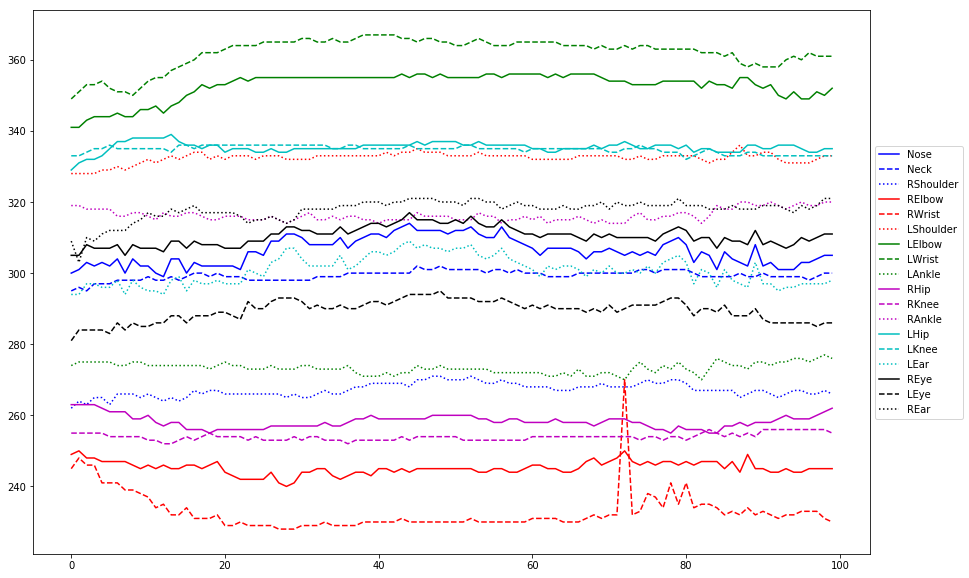

In [8]:
%matplotlib inline

lengends = df_timeseries_x.columns
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

style = ['b-','b--','b:','r-','r--','r:','g-','g--','g:','m-','m--','m:','c-','c--','c:','k-','k--','k:']

# df_timeseries_x.plot(ax=ax)

x = np.arange(10)
for i in xrange(len(lengends)):
    line, = ax.plot(df_timeseries_x.iloc[:,i],style[i],label=lengends[i])
    
# Put a legend below current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

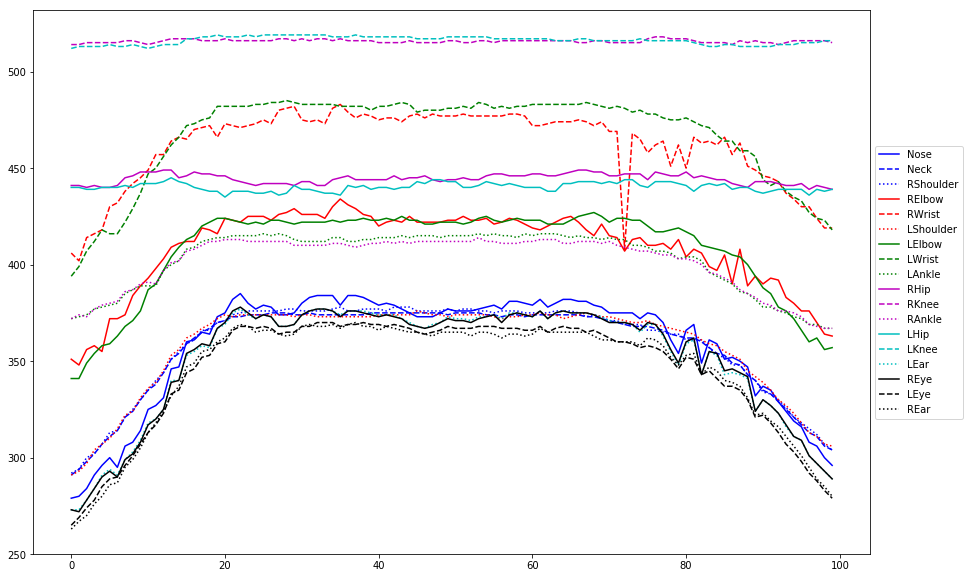

In [9]:
%matplotlib inline

lengends = df_timeseries_x.columns
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

style = ['b-','b--','b:','r-','r--','r:','g-','g--','g:','m-','m--','m:','c-','c--','c:','k-','k--','k:']

# df_timeseries_x.plot(ax=ax)

x = np.arange(10)
for i in xrange(len(lengends)):
    line, = ax.plot(df_timeseries_y.iloc[:,i],style[i],label=lengends[i])
    
# Put a legend below current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [10]:
df_timeseries_x.columns

Index([u'Nose', u'Neck', u'RShoulder', u'RElbow', u'RWrist', u'LShoulder',
       u'LElbow', u'LWrist', u'LAnkle', u'RHip', u'RKnee', u'RAnkle', u'LHip',
       u'LKnee', u'LEar', u'REye', u'LEye', u'REar'],
      dtype='object')

In [18]:
xdata = df_timeseries_x[u'RElbow']
xdata

0     249
1     250
2     248
3     248
4     247
5     247
6     247
7     247
8     246
9     245
10    246
11    245
12    246
13    245
14    245
15    246
16    246
17    245
18    246
19    247
20    244
21    243
22    242
23    242
24    242
25    242
26    244
27    241
28    240
29    241
     ... 
70    247
71    248
72    250
73    247
74    246
75    247
76    246
77    247
78    247
79    246
80    247
81    246
82    247
83    247
84    247
85    245
86    247
87    244
88    249
89    245
90    245
91    244
92    244
93    245
94    244
95    244
96    245
97    245
98    245
99    245
Name: RElbow, Length: 100, dtype: object

In [ ]:
# from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# xdata = np.linspace(0, 4, 100)
y = func(xdata, 2.5, 1.3, 0.5)

popt, pcov = curve_fit(func, xdata, ydata)

array([0.        , 0.08163265, 0.16326531, 0.24489796, 0.32653061,
       0.40816327, 0.48979592, 0.57142857, 0.65306122, 0.73469388,
       0.81632653, 0.89795918, 0.97959184, 1.06122449, 1.14285714,
       1.2244898 , 1.30612245, 1.3877551 , 1.46938776, 1.55102041,
       1.63265306, 1.71428571, 1.79591837, 1.87755102, 1.95918367,
       2.04081633, 2.12244898, 2.20408163, 2.28571429, 2.36734694,
       2.44897959, 2.53061224, 2.6122449 , 2.69387755, 2.7755102 ,
       2.85714286, 2.93877551, 3.02040816, 3.10204082, 3.18367347,
       3.26530612, 3.34693878, 3.42857143, 3.51020408, 3.59183673,
       3.67346939, 3.75510204, 3.83673469, 3.91836735, 4.        ])